Part 1: GANs

In [1]:
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [2]:
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from IPython import display

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# summarize the shape of the dataset
print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [4]:
trn_imag = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
trn_imag = train_images.astype('float32')
trn_imag = (trn_imag - 127.5) / 127.5  # Normalize the images to [-1, 1]

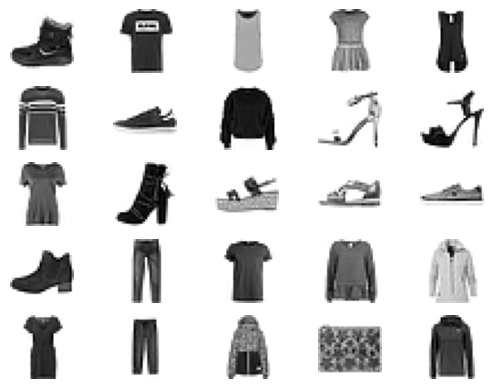

In [5]:
for i in range(25):
  plt.subplot(5, 5, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(train_images[i], cmap='gray_r')
plt.show()


In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
trn_data = tf.data.Dataset.from_tensor_slices(trn_imag).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Step2. Train the GAN model to produce images in this new domain.

In [8]:
def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())

    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())

   # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())

    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)

    return modelG

In [9]:
# sample image generated by the the generator
genG = genG_model()

In [10]:
def make_discriminator_model():
    modelD = tf.keras.Sequential()

    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD

In [11]:
discriM = make_discriminator_model()

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriM_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [14]:
def genG_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
# Create a folder to store weights
if not os.path.exists('training_checkpoints'):
    os.mkdir('training_checkpoints')
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                 discriM_optimizer=discriM_optimizer,
                                 genG=genG,
                                 discriM=discriM)

In [17]:
#defining the number of epochs to train for
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
def trn_img(images, params):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = params['generator'](noise, training=True)

        real_output = params['discriminator'](images, training=True)
        fake_output = params['discriminator'](generated_images, training=True)

        gen_loss = params['generator_loss'](fake_output)
        disc_loss = params['discriminator_loss'](real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    params['generator_optimizer'].apply_gradients(zip(grad_genG, params['generator'].trainable_variables))
    params['discriminator_optimizer'].apply_gradients(zip(grad_discriM, params['discriminator'].trainable_variables))

In [19]:
def sv_img(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
def train(dataset, epochs, params):
    start_time = time.time()

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            trn_img(image_batch, params)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        sv_img(params['generator'], epoch + 1, seed)

        # Save the model every 15 epochs
        # if (epoch + 1) % 15 == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    sv_img(params['generator'], epochs, seed)

    print ('Training Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start_time))

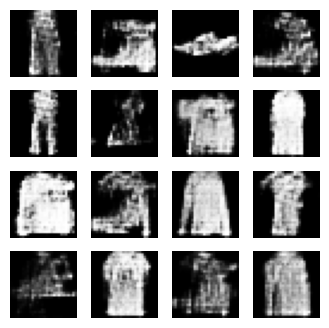

Training Time for epoch 50 is 10369.372624874115 sec


In [21]:
parameters = {
    'generator': genG,
    'discriminator': discriM,
    'generator_loss': genG_loss,
    'discriminator_loss': discriM_loss,
    'generator_optimizer': genG_optimizer,
    'discriminator_optimizer': discriM_optimizer
}

train(trn_data, EPOCHS, parameters)

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

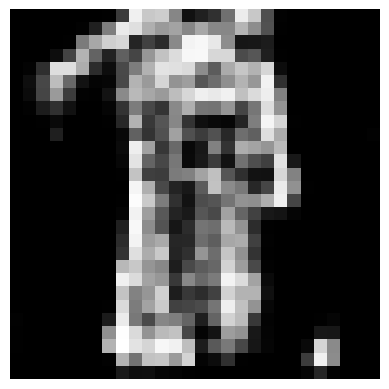

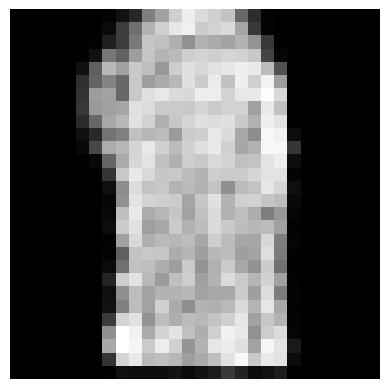

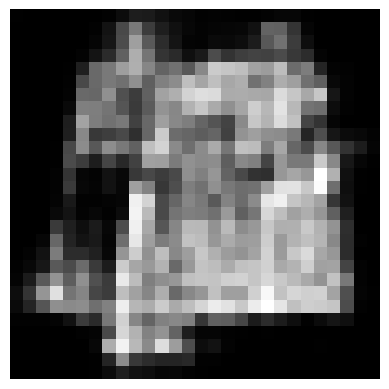

In [23]:
noises = [tf.random.normal([1, 100]) for _ in range(3)] # latent space
generated_images = [genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.savefig('gan_image_{:04d}.png'.format(i))
    plt.show()

The only trouble so far is the long training time, which took more than 3 hours. Therefore, using T4 GPU on Google Colab sped up the process 10 times. Nevertheless, creating and saving the images generated by GAN after training have no troubles at all.

Step4. Save the model weights in the folder to be used later.

In [24]:
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints\\ckpt-1'

Step 5. Load the model using the saved weights.

In [24]:
# genG = genG_model()
# discriM = make_discriminator_model()

In [25]:
# Restore the models' weights
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# genG.load_weights('./training_checkpoints/ckpt-1')

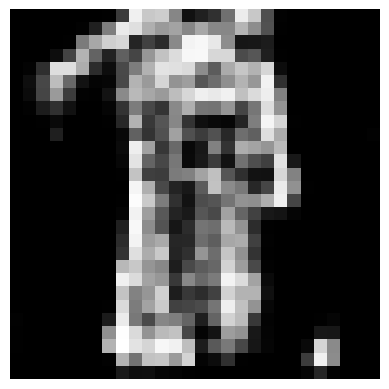

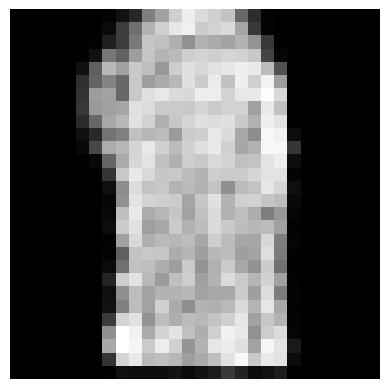

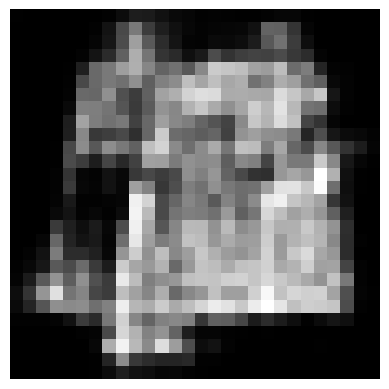

In [26]:
# Confirming the model's weights are loaded
generated_images = [checkpoint.genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.show()

Step 6: Re-train the GAN model to see if you can improve.

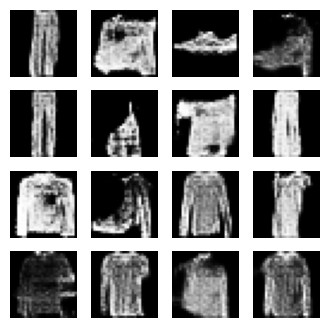

Training Time for epoch 50 is 10497.444955825806 sec


In [27]:
parameters['generator'] = checkpoint.genG
parameters['discriminator'] = checkpoint.discriM

train(trn_data, EPOCHS, parameters)

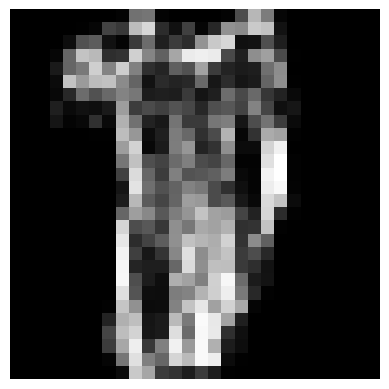

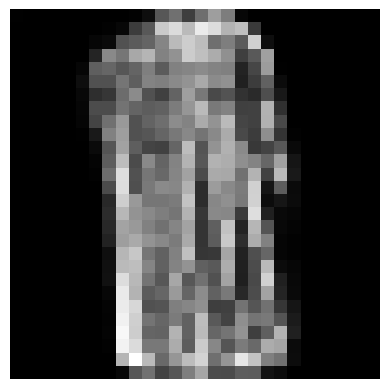

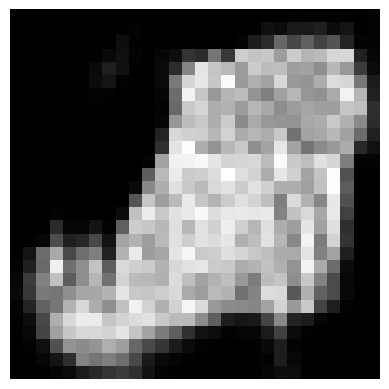

In [28]:
generated_images = [checkpoint.genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.show()

Step 7: Save the model weights without using checkpoints.

In [29]:
g_wg_path = 'gen_weights.h5'
genG_weights = checkpoint.genG.save_weights(g_wg_path, overwrite=True)

d_wg_path = 'discrim_weights.h5'
discriM_weights = checkpoint.discriM.save_weights(d_wg_path, overwrite=True)

Step 8: Load the model weights without using checkpoints.

In [30]:
genG = genG_model()
genG.load_weights(g_wg_path)

discriM = make_discriminator_model()
discriM.load_weights(d_wg_path)

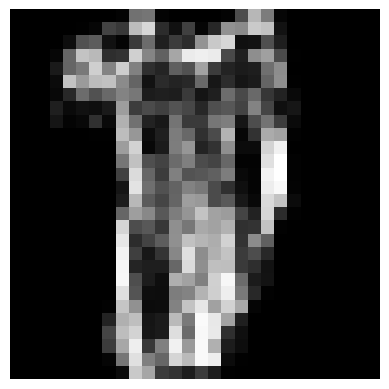

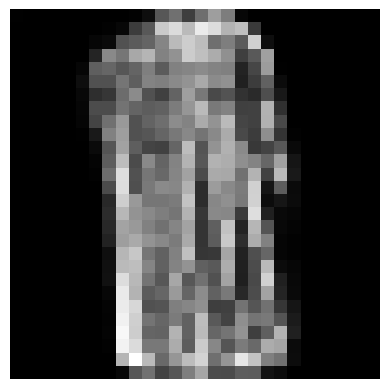

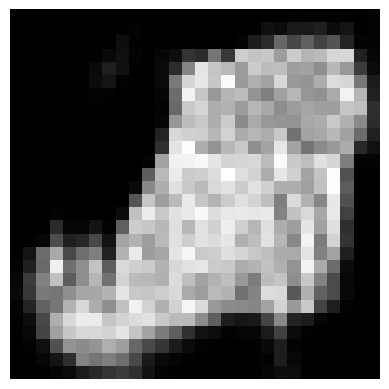

In [31]:
generated_images = [genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.show()

Part 2 LSGAN:

Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [32]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Step2. Train the GAN model to produce images in this new domain.

In [33]:
mse_loss = tf.keras.losses.MeanSquaredError()

def genG_loss(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

In [34]:
genG = genG_model()
discriM = make_discriminator_model()

In [35]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [36]:
if not os.path.exists('training_checkpoints_ls'):
    os.mkdir('training_checkpoints_ls')
checkpoint_dir_ls = './training_checkpoints_ls'
checkpoint_prefix_ls = os.path.join(checkpoint_dir_ls, "ckpt")
checkpoint_ls = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                    discriM_optimizer=discriM_optimizer,
                                    genG=genG,
                                    discriM=discriM)

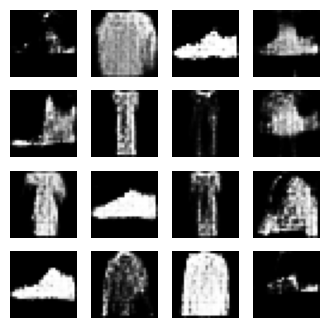

Training Time for epoch 50 is 11559.221376419067 sec


In [37]:
parameters = {
    'generator': genG,
    'discriminator': discriM,
    'generator_loss': genG_loss,
    'discriminator_loss': discriM_loss,
    'generator_optimizer': genG_optimizer,
    'discriminator_optimizer': discriM_optimizer
}

train(trn_data, EPOCHS, parameters)

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

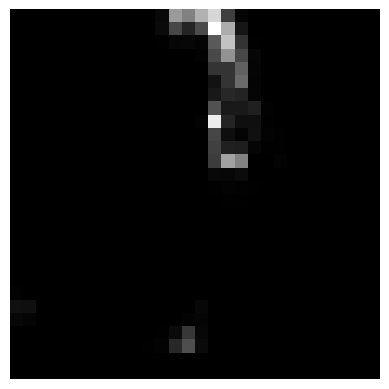

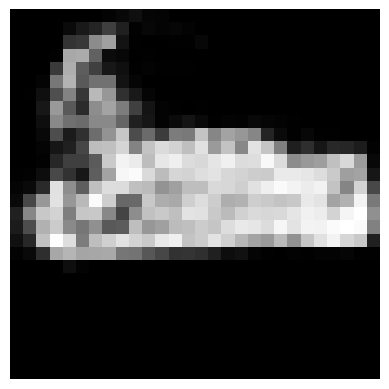

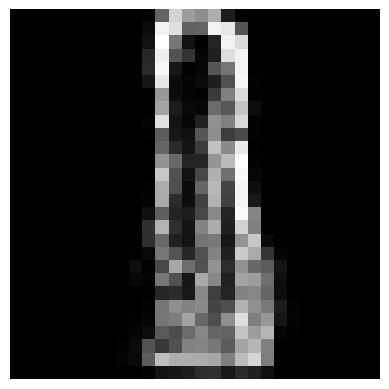

In [38]:
generated_images = [genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.savefig('ls_gan_image_{:04d}.png'.format(i))
    plt.show()

Step4. Save the model weights in the folder to be used later.

In [39]:
checkpoint_ls.save(file_prefix = checkpoint_prefix_ls)

'./training_checkpoints_ls\\ckpt-1'

Step5. Load the model using the saved weights.

In [ ]:
# genG = genG_model()
# discriM = make_discriminator_model()

In [40]:
checkpoint_ls.restore(tf.train.latest_checkpoint(checkpoint_dir_ls))

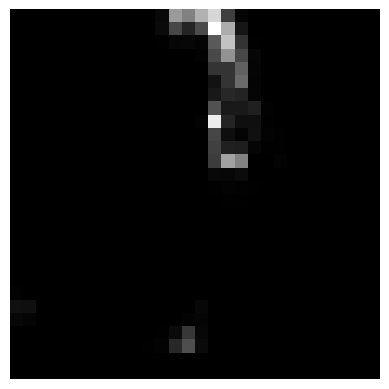

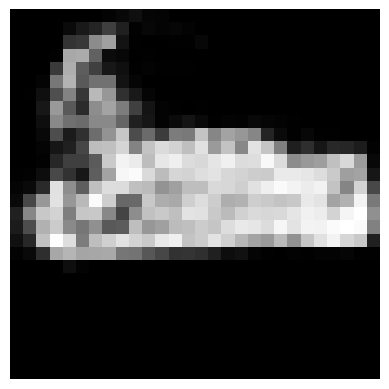

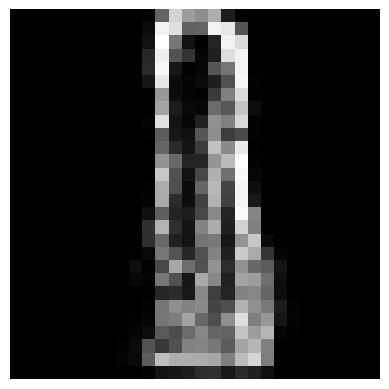

In [41]:
generated_images = [checkpoint_ls.genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.show()

Step 6: Re-train the GAN model to see if you can improve.

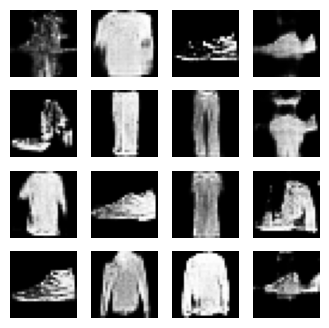

Training Time for epoch 50 is 10509.90864777565 sec


In [42]:
parameters['generator'] = checkpoint_ls.genG
parameters['discriminator'] = checkpoint_ls.discriM

train(trn_data, EPOCHS, parameters)

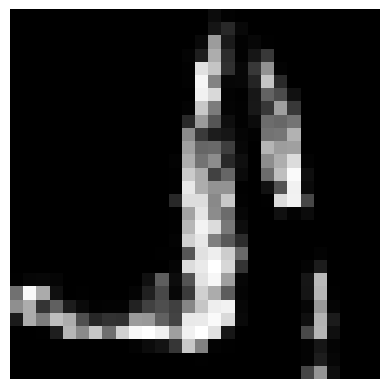

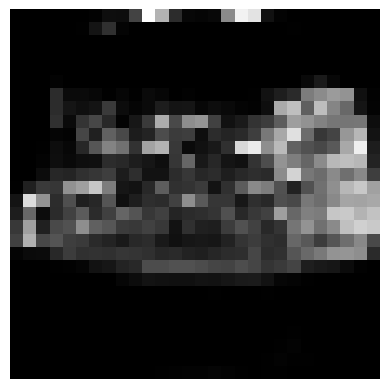

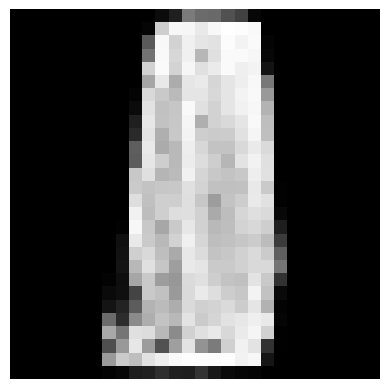

In [43]:
generated_images = [checkpoint_ls.genG(noise, training=False) for noise in noises]

for i, gi in enumerate(generated_images):
    plt.axis('off')
    plt.imshow(gi[0, :, :, 0], cmap='gray')
    plt.show()

GAN takes less time to train than LS GAN. Also, GAN produces more consisten images after re-training. We could assume that LS GAN might be overfitting after training with the same dataset. In my case, GAN would be a better choice if I am to use it generate fakes images.